# Image Classification with Traditional ML Models

## Overview

The goal of this project is to classify the category of a given image using traditional machine learning models, which require manual feature selection and engineering. We are given 1501 images belonging to 20 different categories to train the models. 

There is also an unclassified test dataset with 716 images, which are used by the course instructor to evaluate our models. We will not be using this dataset since it would require us to manually encode each image to validate predictions. To evaluate our models, we will set aside 10% of the training dataset to be our validation dataset.

The project was initially completed with Nate Tsang and Thor Valentin Olesen as part of a project in our graduate data science class at UC Berkeley. I later revisited the project to improve the models.

#### Data Used
- 20_categories_training.zip

#### Models Trained
- Logistic Regression
- KNN
- SVM
- Random Forest

#### Procedure to Train Models

After preparing and transforming the data, we will split the dataset into train and test sets (90/10). The test set is used only for calculating validation accuracy.

For each model:
1. Identify hyperparameters to test using cross validation
2. Find best hyperparameters using CV_with_GridSearch function
3. Instantiate model using optimal hyperparameters found in the previous step
4. Fit model and calculate model accuracy on train and test data using estimate_model_results function
5. Bootstrap accuracy confidence intervals by setting boostrap_results=True

#### Results
<img src="results.png" style="float:left;width:400px">

## Libraries

In [36]:
# Data manipulations
import numpy as np
import pandas as pd
import os
import zipfile 
from zipfile import ZipFile
import re 
import skimage
from skimage import io
from pathlib import Path
import scipy
import scipy.cluster
import binascii
import webcolors 
from PIL import Image # for opening an image

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Image feature extraction
from skimage.feature import *
from skimage.transform import resize, rescale
from skimage.exposure import histogram
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage import filters 

# Model training
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample

## Data Load

First, we need to load the images into a dataframe for processing later on. We extract the following information from the jpg files stored in category-specific folders:
- name: name of the file
- image: array containing image pixels
- category: name of the category
- encoding: category encoding for validating predictions

We will also create RGB representations for all grayscale images for data consistency when generating the dataframe. For info on how images are represented in computers, see this link: https://freecontent.manning.com/the-computer-vision-pipeline-part-2-input-images/.

In [2]:
def convert_gray(images):
    """
    Creates RGB representation of gray-level images. 
    
    Keyword arguments: 
    images (pd.Series) -- array containing image pixels 
    
    Returns: 
        ndarray of images all with RGB representation
        
    """
    return images.apply(lambda image: skimage.color.grey2rgb(image) if len(image.shape) < 3 else image) 

In [3]:
def read_organize_data(isTest=False, isCache=True):    
    """
    Returns a dataframe with picture objects and category encodings of all images in folder. 
    
    Keyword arguments:
    isTest (bool) -- Flag. True loads images from test set, False loads train set.
    isCache (bool) -- Flag. True loads images from cache, False overwrites cached images.
        
    Return: 
        pd.DataFrame with image objects and category encodings 
    """
    image_names, category_names, images = [], [], []
    cache_path = 'cleaned_test.pkl' if isTest else 'cleaned_train.pkl'
    file_path = '20_Validation' if isTest else '20_categories_training'
    img_dir_path = Path(f"{os.getcwd()}/{file_path}.zip") 
    
    zip_files = zipfile.ZipFile(img_dir_path)
    zip_files.extractall(f"{os.getcwd()}/{file_path}/")
    
    # If cache file exists, read from it
    if Path(cache_path).is_file() and isCache: 
        print(f"Loading cache {'test' if isTest else 'train'} file")
        return pd.read_pickle(cache_path)
    
    # Read through unzipped files and search for filenames that end with 'jpg'
    for filename in zip_files.namelist(): 
        img_name = re.search("^.*.jpg", filename)
        if img_name is not None and "/._" not in img_name.group(): 
            if ' ' in img_name.group(): 
                continue 
            image_names.append(img_name.group())

        if isTest: 
            img_path = Path(f"{file_path}/{img_name.group()}")
            images.append( io.imread( img_path ) )
            continue 

        category_name = re.search("(.*)/", filename)
        if category_name and "/._" not in img_name.group(): 
            category_name = category_name.group().replace("/", "")
            category_names.append(category_name)
            category_path = Path(f"{file_path}/{img_name.group()}")
            image = io.imread(category_path)
            images.append(image)
    
    # Generate a dataframe with picture objects
    df = pd.DataFrame() 
    df['name'] = image_names
    df['image'] = convert_gray(images)
    
    # For test data, create column with encodings in order to validate predictions
    if not isTest: 
        df['category'] = category_names
        encoding = {0:'airplanes', 1:'bear', 2:'blimp', 3:'comet', 4:'crab', \
                    5:'dog', 6:'dolphin', 7:'giraffe', 8:'goat', 9:'gorilla', \
                    10:'kangaroo', 11:'killer-whale', 12:'leopards', 13:'llama', \
                    14:'penguin', 15:'porcupine', 16:'teddy-bear', 17:'triceratops', \
                    18:'unicorn', 19:'zebra'}
        encoding = {v: k for k, v in encoding.items()}
        df['encoding'] = df['category'].map(encoding)
    
    # Create cache file
    if not Path(cache_path).is_file() or isCache is False: 
        df.to_pickle(f"./{cache_path}")
    
    return df

In [4]:
import time 
t1 = time.time()
training_data = read_organize_data(isTest=False, isCache=True)
t2 = time.time()
print(f"Seconds: {round(t2 - t1, 2)}")
print(f"Training images loaded: {len(training_data)}")

Loading cache train file
Seconds: 4.66
Training images loaded: 1501


Let's take a quick look at the data to make sure it's in the right format.

In [5]:
training_data.head()

,name,image,category,encoding
0,airplanes/airplanes_0001.jpg,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",airplanes,0
1,airplanes/airplanes_0002.jpg,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",airplanes,0
2,airplanes/airplanes_0003.jpg,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",airplanes,0
3,airplanes/airplanes_0004.jpg,"[[[174, 190, 187], [173, 189, 186], [172, 188,...",airplanes,0
4,airplanes/airplanes_0005.jpg,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",airplanes,0


## Exploratory Data Analysis

Now, let's understand our data better to determine if any data transformation is needed. This process will also give us an idea of what features we could look at when training our models. We will be looking at the following:
- Distribution of categories
- Distribution of image size by category
- Distribution of image ratio by category
- Dominant colors by category

#### Distribution of categories

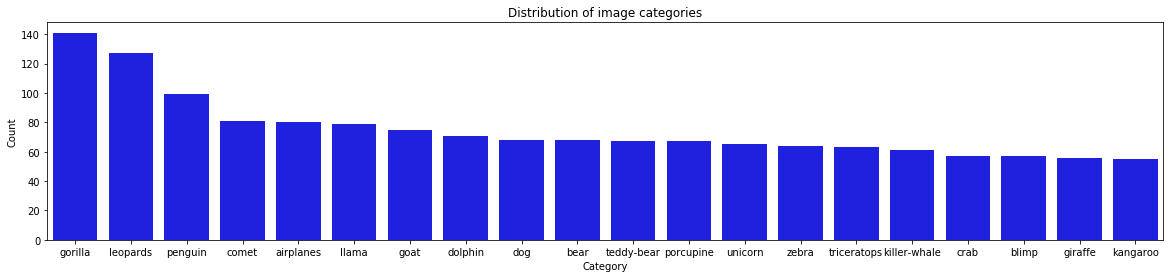

Number of images in the training dataset: 1501


In [6]:
# Distribution of categories 
category_distribution = (training_data['category']
                         .value_counts()
                         .reset_index()) 
plt.figure(figsize=(20,4))
ax = sns.barplot(x='index', 
                 y='category', 
                 data=category_distribution, 
                color='blue')
ax.set_title('Distribution of image categories')
ax.set_xlabel('Category')
ax.set_ylabel('Count')
plt.show()
print("Number of images in the training dataset: " + str(len(training_data)))

There are two things we can see from the above barplot.
1. Data is unbalanced, which might lead to a prediction bias. 
2. There are not a lot of images to train the models, considering that there are 20 categories in total. 

In the next section, we will explore ways to create more images to tackle the above issues.

#### Distribution of image size by category

In [7]:
training_data['size'] = training_data['image'].apply(lambda image: image.size)

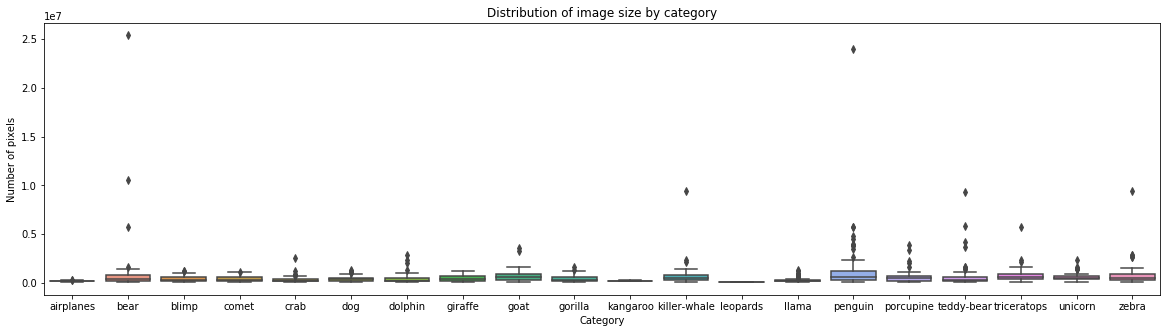

In [8]:
plt.figure(figsize=(20,5))
ax = sns.boxplot(x="category", y="size", data=training_data)
ax.set_title('Distribution of image size by category')
ax.set_xlabel('Category')
ax.set_ylabel('Number of pixels')
plt.show()

Let's try to exclude the outliers to get a better visualization of the distributions.

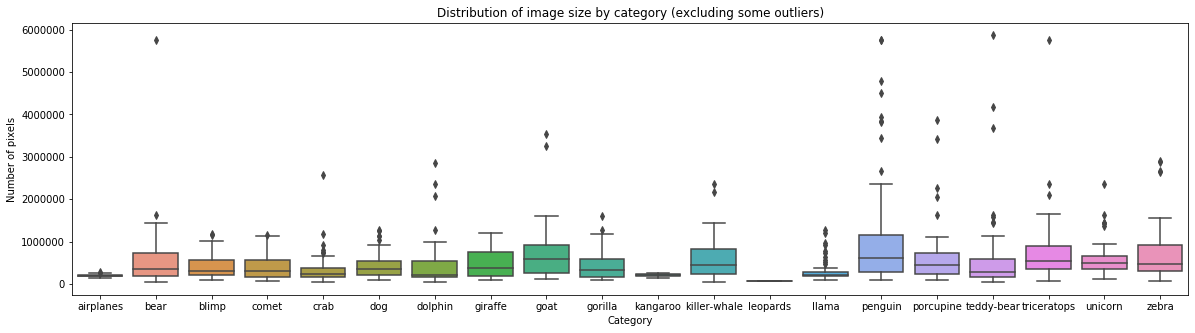

In [9]:
plt.figure(figsize=(20,5))
ax = sns.boxplot(x="category", y="size", data=training_data[training_data['size']<=8000000])
ax.set_title('Distribution of image size by category (excluding some outliers)')
ax.set_xlabel('Category')
ax.set_ylabel('Number of pixels')
plt.show()

We can see from the boxplot above that most categories have some images that are very large in size. While this isn't really a data issue, we will try to scale down some of these large images to improve processing speed.

#### Distribution of image ratio by category

Image ratio is defined as width/height. A ratio of more than 1 means that the image is horizontal.

In [10]:
training_data['ratio'] = training_data['image'].apply(lambda image: 
                                                      image.shape[1]/image.shape[0])

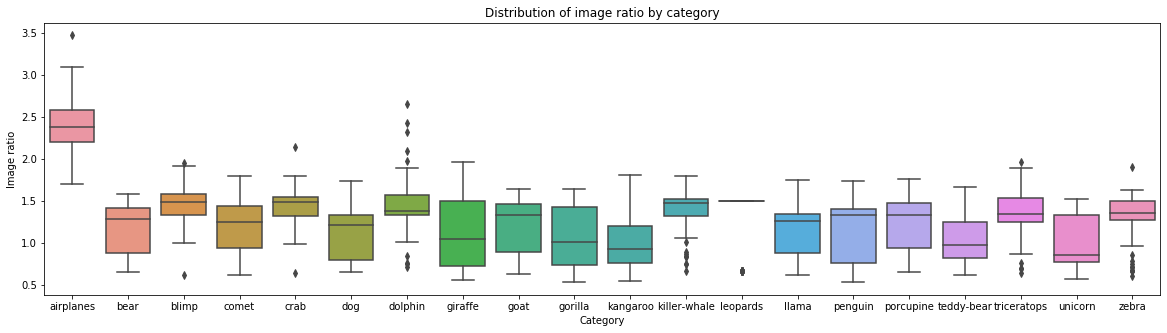

In [11]:
plt.figure(figsize=(20,5))
ax = sns.boxplot(x="category", y="ratio", data=training_data)
ax.set_title('Distribution of image ratio by category')
ax.set_xlabel('Category')
ax.set_ylabel('Image ratio')
plt.show()

Two interesting observations from this graph.
1. All airplane images are horizontal, which makes sense because of how airplanes fly. 
2. Most leopard images have the same size, an observation that is also shown in the image size visualization.

#### Dominant colors by category

In [12]:
# These functions are used to find the dominant color clusters from images. 
# The color distribution is found by K-Means Clustering pixels into K groups of similar colors.
def closest_color(requested_color):
    """
    Finds the RGB color that is closed to the requested color.
    
    Keyword arguments: 
    requested_color (3-tuple) -- color to match. 
    
    Returns: 
        Closest RGB colour (3-tuple)
    """
    min_colors = {}
    for key, name in webcolors.css3_hex_to_names.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_color[0]) ** 2
        gd = (g_c - requested_color[1]) ** 2
        bd = (b_c - requested_color[2]) ** 2
        min_colors[(rd + gd + bd)] = name
    return min_colors[min(min_colors.keys())]

def get_color_name(requested_color):
    """
    Convert a color (3-tuple of ints) into its color name if it exists.
    
    Keyword arguments:
    requested_color -- color to match a name for.
    
    Returns: 
        name of color (string) 
    """
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_color)
    except ValueError:
        closest_name = closest_color(requested_color)
        actual_name = None
    return actual_name, closest_name

def get_color_name_from_image(image_path):
    """
    Finds the color distribution of the image,
    by K-Means clustering pixels into K groups of similar colors.
    
    Keyword arguments: 
    image_path -- path of the image 
    
    Returns: 
        color name of most domiant color (string) 
    """
    NUM_CLUSTERS = 5
    im = Image.open(image_path)
    im = im.resize((150, 150)) # optional, reduce time
    ar = np.asarray(im)
    shape = ar.shape
    ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype(float)
    codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)

    vecs, dist = scipy.cluster.vq.vq(ar, codes) # assign codes
    counts, bins = scipy.histogram(vecs, len(codes)) # count occurrences

    index_max = scipy.argmax(counts) # find most frequent
    peak = codes[index_max]
    input = ''.join(chr(int(c)) for c in peak)
    color = binascii.hexlify ( bytes(input, 'utf-8') )
    hex_code = "#" + str(color).replace('b', '').replace("'", "")
    _, color_name = get_color_name(peak)
    return color_name 

def get_dominant_colors(image_folder='20_categories_training', cache_file='./colors.pkl'): 
    """
    Returns the most dominant colors for all images in specified folder.
    
    Keyword arguments:
    image_folder (string) -- path of image folder specified from root.
    cache_file (string) -- name of file used to cache results locally. 
    
    Returns: 
        pd.DataFrame containing the most dominant color names of all images 
    """
    if Path(cache_file).is_file(): 
        return pd.read_pickle(cache_file)
    
    popular_colors = []
    for parent_dir, sub_dir, files in os.walk(image_folder):
        for file in files:
            if ' ' not in file and not file.startswith('.'): 
                file_path = os.path.join(parent_dir, file)
                try: 
                    dominant_color = get_color_name_from_image(file_path)
                    popular_colors.append(dominant_color)
                except: 
                    continue # RGB (3-tuple) invalid
    colors_df = pd.DataFrame(np.array(popular_colors), columns=['color'])                
    
    if not Path(cache_file).is_file(): 
        colors_df.to_pickle(cache_file)
    return colors_df

def ensure_dir(file_path):
    """
    Check if directory exists or create it.
    This is used to to store cached color files.
    """
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

In [13]:
# Distribution of colors by category 
ensure_dir("./colors/")
colors_by_category = pd.DataFrame
for category_name in os.listdir('20_categories_training'): # find colors by category 
    # If cache file exists, read from it
    if Path(f'colors/{category_name}_colors.pkl').is_file(): 
        print(f"Loading cache {category_name}_colors file")
        continue
    if not category_name.startswith('.'): # hidden files 
        print(f"Finding dominant colors for category: {category_name}")
        category_colors = get_dominant_colors(f"20_categories_training/{category_name}", 
                                              cache_file=f'colors/{category_name}.pkl')

Loading cache gorilla_colors file
Loading cache crab_colors file
Loading cache blimp_colors file
Loading cache airplanes_colors file
Loading cache dog_colors file
Loading cache dolphin_colors file
Loading cache giraffe_colors file
Loading cache bear_colors file
Loading cache killer-whale_colors file
Loading cache penguin_colors file
Loading cache zebra_colors file
Loading cache goat_colors file
Loading cache triceratops_colors file
Loading cache porcupine_colors file
Loading cache teddy-bear_colors file
Loading cache comet_colors file
Loading cache leopards_colors file
Loading cache kangaroo_colors file
Loading cache unicorn_colors file
Loading cache llama_colors file


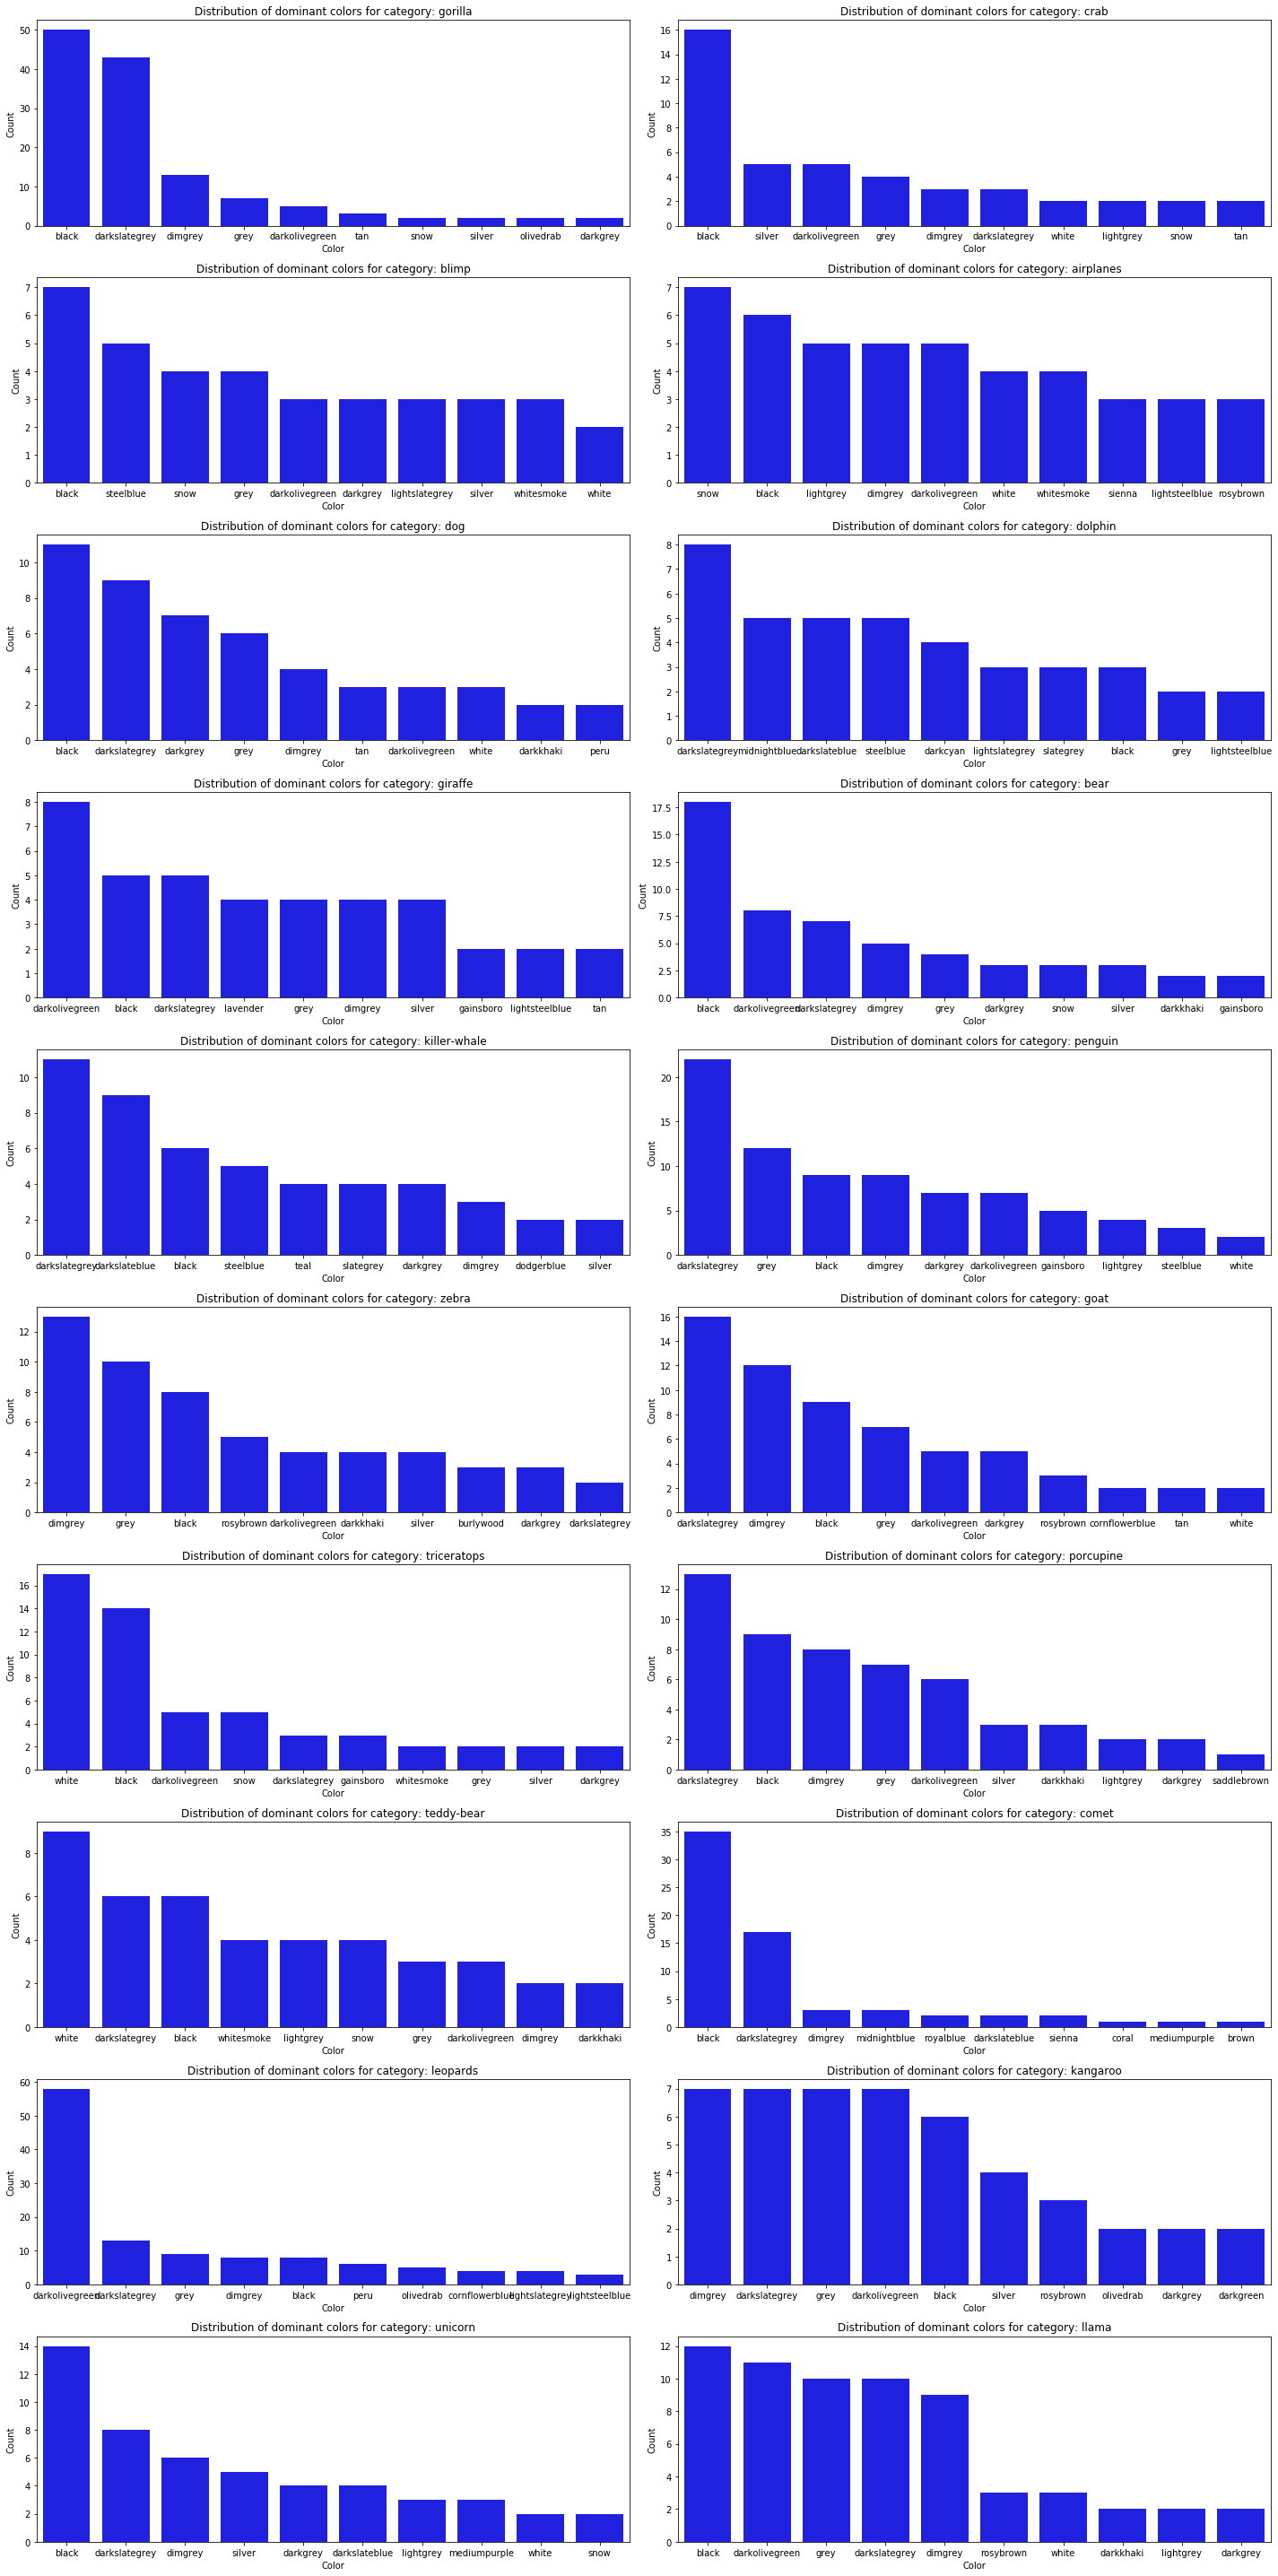

In [14]:
# Plotting all the subplots
fig, axes = plt.subplots(10, 2, figsize=(20,40))
x = 0
y = 0

for category_name in os.listdir('20_categories_training'): # plot colors by category  
    if not category_name.startswith('.'): # hidden files 
        category_colors = pd.read_pickle(f'colors/{category_name}_colors.pkl')
        dominant_category_colors = (category_colors['color']
                                    .value_counts()
                                    .nlargest(10)
                                    .reset_index()) 
        color_plot = sns.barplot(x='index', 
                                 y='color', 
                                 data=dominant_category_colors, 
                                 color='blue',
                                 ax=axes[x,y])
        color_plot.set_title(f'Distribution of dominant colors for category: {category_name}')
        color_plot.set_xlabel('Color')
        color_plot.set_ylabel('Count')
        y += 1
        if y == 2:
            x += 1
            y = 0

plt.tight_layout()
plt.show()

From the above, we can see that the most dominant color for some categories do not always match our expectations. For instance, one would expect the most dominant color for both giraffes and leopards is orange-brown. For both of these categories, the most dominant color is dark olive green, which is possibly due to the image background of a forest. 

On the other hand, we also noticed that color may not be a helpful feature for identifying some categories. For instance, dogs can have different colors based on their breeds, while airplanes have different colors based on the designs of the company. 

## Data Transformation

From our EDA, we decided to do the following to prepare the dataset for training our models.
1. Image downscale
2. Data augmentation

#### Image downscale

We will scale all images with more than 3 million pixels by a factor of 0.25.

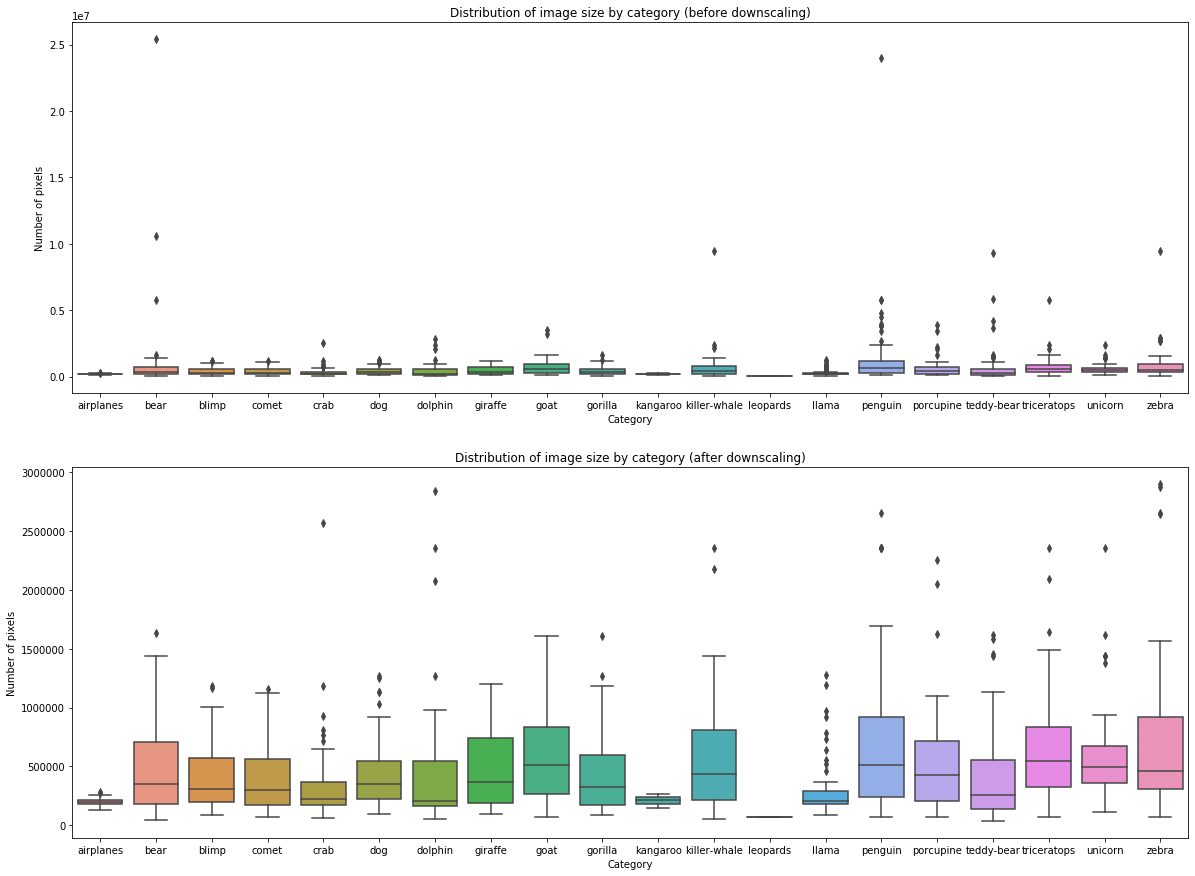

In [15]:
training_data['image'] = training_data['image'].apply(lambda image: rescale(image, 0.25) 
                                                      if image.size > 3000000 else image)
training_data['new_size'] = training_data['image'].apply(lambda image: image.size)
fig, axes = plt.subplots(2, 1, figsize=(20,15))
plt1 = sns.boxplot(x="category", y="size", data=training_data, ax=axes[0])
plt1.set_title('Distribution of image size by category (before downscaling)')
plt1.set_xlabel('Category')
plt1.set_ylabel('Number of pixels')

plt2 = sns.boxplot(x="category", y="new_size", data=training_data, ax=axes[1])
plt2.set_title('Distribution of image size by category (after downscaling)')
plt2.set_xlabel('Category')
plt2.set_ylabel('Number of pixels')
plt.show()

#### Data augmentation

We will create more images using the following technique:
1. Add random noise
2. Horizontal flip
3. Vertical flip
4. Contrast adjustment

The last 2 techniques will only be applied to a subset of categories in an attempt to balance the number of images for each category.

In [16]:
# Add random noise
train_noise = training_data.copy()
train_noise['image'] = train_noise['image'].apply(lambda image:
                                                 skimage.util.random_noise(image, mode='gaussian', seed=None))

# Horizontal flip
train_flip = training_data.copy()
train_flip['image'] = train_flip['image'].apply(lambda image: image[:, ::-1])

# Vertical flip for a subset of categories
exclude = ['gorilla', 'leopards', 'penguin']
train_selective_flip = training_data[(training_data['category'] != exclude[0]) &
                                     (training_data['category'] != exclude[1]) &
                                     (training_data['category'] != exclude[2])].copy()
train_selective_flip['image'] = train_selective_flip['image'].apply(lambda image: image[::-1, :])

# Contrast adjustment for a subset of categories
train_selective_contrast = training_data[(training_data['category'] != exclude[0]) &
                                         (training_data['category'] != exclude[1]) &
                                         (training_data['category'] != exclude[2])].copy()
train_selective_contrast['image'] = train_selective_contrast['image'].apply(lambda image:
                                                                           skimage.exposure.adjust_sigmoid(image))

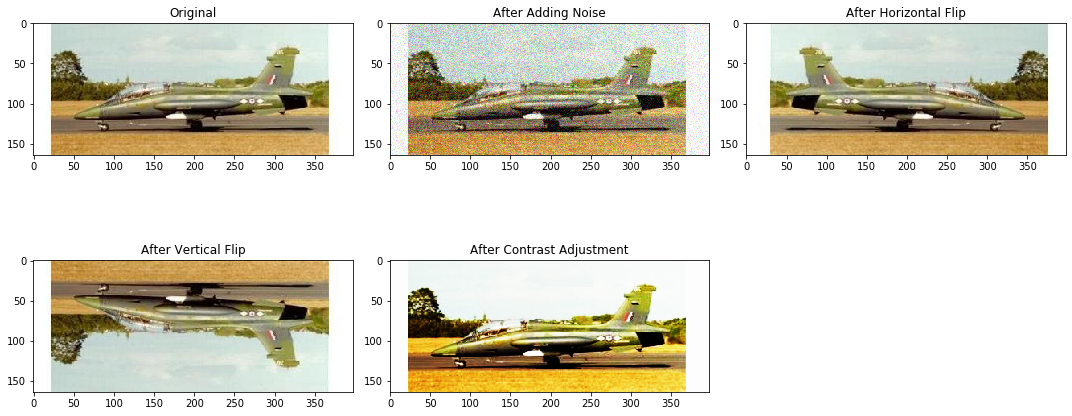

In [17]:
# Visualize the changes
fig, axes = plt.subplots(2, 3, figsize=(15,7))
axes[0,0].imshow(training_data['image'][0])
axes[0,0].set_title('Original')
axes[0,1].imshow(train_noise['image'][0])
axes[0,1].set_title('After Adding Noise')
axes[0,2].imshow(train_flip['image'][0])
axes[0,2].set_title('After Horizontal Flip')
axes[1,0].imshow(train_selective_flip['image'][0])
axes[1,0].set_title('After Vertical Flip')
axes[1,1].imshow(train_selective_contrast['image'][0])
axes[1,1].set_title('After Contrast Adjustment')
fig.delaxes(axes[1,2])
plt.tight_layout()
plt.show()

Now, let's put all the images in the same dataframe and visualize the new distribution.

In [18]:
training_data_combined = pd.concat([training_data, train_noise, train_flip, 
                                    train_selective_flip, train_selective_contrast], sort=False).reset_index()

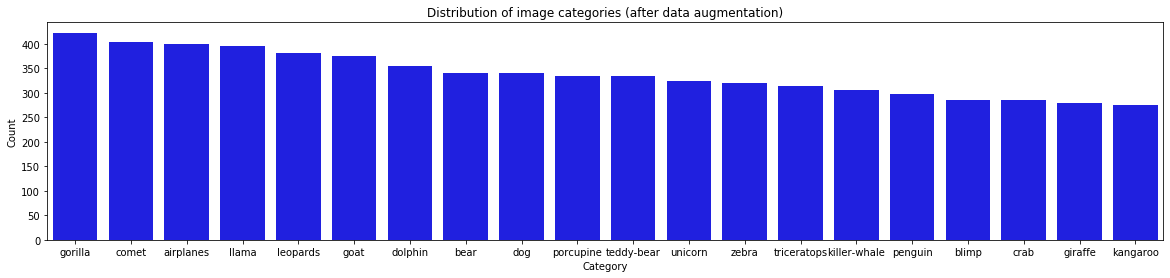

Number of images in the augmented training dataset: 6771


In [19]:
new_category_distribution = (training_data_combined['category']
                             .value_counts()
                             .reset_index()) 
plt.figure(figsize=(20,4))
ax = sns.barplot(x='index', 
                 y='category', 
                 data=new_category_distribution, 
                color='blue')
ax.set_title('Distribution of image categories (after data augmentation)')
ax.set_xlabel('Category')
ax.set_ylabel('Count')
plt.show()
print("Number of images in the augmented training dataset: " + str(len(training_data_combined)))
# new_category_distribution['perc'] = new_category_distribution['category']/len(training_data)
# new_category_distribution

Not perfect but much better than before!

## Feature Engineering

Since we are using traditional machine learning models (instead of deep learning models), we need to manually create features to train our models on. We will do so by following these steps:
1. List possible features
2. Add them to our dataframe
3. Use ensemble of decision trees to find best features for category prediction
4. Generate train and validation dataframes using only the best features

#### Listing possible features

References:
1. https://freecontent.manning.com/the-computer-vision-pipeline-part-4-feature-extraction/
2. https://scikit-image.org/docs/dev/api/skimage.feature.html
3. https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_table_of_contents_feature2d/py_table_of_contents_feature2d.html

In [20]:
def ft0(images):
    """ Returns the pixel size of the image arrays"""
    return images.size

def ft1(images): 
    """ Returns aspect ratio of the image arrays """
    return images.shape[1] / images.shape[0]

def ft2(images):
    """ Returns the average of the red-channel in image array """
    red_channel = images[:, :, 0]
    return np.mean ( red_channel )

def ft3(images):
    """ Returns the average of the green-channel in image array """
    green_channel = images[:, :, 1]
    return np.mean ( green_channel )
        
def ft4(images):
    """ Returns the average of the blue-channel in image array """
    blue_channel = images[:, :, 2]
    return np.mean ( blue_channel )

def ft5(images):
    """ Returns the median of the red-channel in image array """
    red_channel = images[:, :, 0]
    return np.median ( red_channel )

def ft6(images):
    """ Returns the median of the green-channel in image array """
    green_channel = images[:, :, 1]
    return np.median ( green_channel )
    
def ft7(images):
    """ Returns the median of the blue-channel in image array """
    blue_channel = images[:, :, 2]
    return np.median ( blue_channel )

def ft8(images):
    """ Returns the stdev of the red-channel in image array """
    red_channel = images[:, :, 0]
    return np.std ( red_channel )
    
def ft9(images):
    """ Returns the stdev of the green-channel in image array """
    green_channel = images[:, :, 1]
    return np.std ( green_channel )

def ft10(images):
    """ Returns the stdev of the blue-channel in image array """
    blue_channel = images[:, :, 2]
    return np.std ( blue_channel )

def ft11(images):
    """Returns the number of corners in the FAST corner response image """
    image_gray = rgb2gray(images)
    return len(corner_peaks(corner_fast(image_gray)))

def ft12(images):
    """Returns the average of the x-coord of the corners in the FAST corner response image"""
    image_gray = rgb2gray(images)
    return np.nanmean(corner_peaks(corner_fast(image_gray))[:,0])

def ft13(images):
    """Returns the average of the y-coord of the corners in the FAST corner response image"""
    image_gray = rgb2gray(images)
    return np.nanmean(corner_peaks(corner_fast(image_gray))[:,1])

def ft14(images):
    """Returns number of peaks (i.e. local max in a region) of images """
    local_max_coordinates = peak_local_max(images)
    return len(local_max_coordinates)

def ft15(images):
    """Returns the average of the x-coord of the peaks"""
    local_max_coordinates = peak_local_max(images)
    return np.nanmean(local_max_coordinates[:,0])

def ft16(images):
    """Returns the average of the y-coord of the peaks"""
    local_max_coordinates = peak_local_max(images)
    return np.nanmean(local_max_coordinates[:,1])

def ft17(images):
    """
    Returns the average shape index of every pixel in the image
    Indices are undefined in flat regions and these values should be excluded by mean function
    """
    image_gray = rgb2gray(images)
    return np.nanmean(shape_index(image_gray))

def ft18(images):
    """Returns the number of pixels in a non flat region"""
    image_gray = rgb2gray(images)
    return np.count_nonzero(~np.isnan(shape_index(image_gray)))

def ft19(images):
    """
    Returns the average luminance of the filtered images
    This is used to approximate the amount of edges in the image
    """
    image_gray = rgb2gray(images)
    return np.mean(filters.sobel(image_gray))

def ft20(images):
    """
    Returns the average of the number of pixels for each value bin in the red-channel
    """
    red_channel = images[:, :, 0]
    return histogram(red_channel)[0].mean()

def ft21(images):
    """
    Returns the average of the number of pixels for each value bin in the green-channel
    """
    green_channel = images[:, :, 1]
    return histogram(green_channel)[0].mean()

def ft22(images):
    """
    Returns the average of the number of pixels for each value bin in the blue-channel
    """
    blue_channel = images[:, :, 2]
    return histogram(blue_channel)[0].mean()

def ft23(images):
    """ 
    Returns the number of blobs (i.e. connected areas) in images using Hessian 
    """
    image_gray = rgb2gray(images)
    blobs_hessian = blob_doh(image_gray)
    return len(blobs_hessian)

#### Add features to dataframe

In [21]:
#Returns data-frame with all the features now inside, and calculated
def feature_frame(images_df, isTest=False, isCache=True):
    """
    Runs all the feature functions on the image dataframe.
    
    Keyword arguments: 
    images_df (pd.DataFrame) -- DataFrame containing all images
    isTest (bool) -- True featurizes test set, False featurizes train set.
    isCache (bool) -- True loads featurized images from cache if exists, false overwrites. 
    
    Returns: 
        pd.DataFrame with all images and their features 
    """
    num_features = 24
    image_series = images_df['image']
    
    cache_file = 'features_test.pkl' if isTest else 'features_train.pkl'
    if Path(cache_file).is_file() and isCache: 
        return pd.read_pickle(cache_file)
    
    features = [f'ft{x}' for x in range(0, num_features)] 
    for feature in features:
        print(f"Started feature: {feature}")
        start = time.time()
        images_df[feature] = eval(f"np.vectorize({feature})(image_series)")
        print(f"Feature '{feature}' took {round(time.time() - start, 2)} seconds")    
    
    if not Path(cache_file).is_file(): 
        images_df.to_pickle(f"./{cache_file}")
        
    print(f"Featurization of {'test' if isTest else 'train'} set completed!")
        
    return images_df

In [22]:
training_features_df = feature_frame(training_data_combined, isTest=False, isCache=True)

Let's check for null values in the dataframe.

In [23]:
training_features_df.isnull().sum()

index        0
name         0
image        0
category     0
encoding     0
size         0
ratio        0
ft0          0
ft1          0
ft2          0
ft3          0
ft4          0
ft5          0
ft6          0
ft7          0
ft8          0
ft9          0
ft10         0
ft11         0
ft12        43
ft13        43
ft14         0
ft15        63
ft16        63
ft17         0
ft18         0
ft19         0
ft20         0
ft21         0
ft22         0
ft23         0
dtype: int64

ft12, ft13, ft15 and ft16 are average x and y coordinates of corners and local peaks. We are getting null values for some images because they do not have any peaks or corners. Since these columns correspond to average positions, it makes sense to replace the null values with 0. 

The more proper solution would be to handle these cases in our feature functions. However, since it takes a long time to derive the value for each feature for the whole dataframe, we will replace the null values manually for now.

In [24]:
training_features_df.fillna(0, inplace=True)
training_features_df.isna().sum()

index       0
name        0
image       0
category    0
encoding    0
size        0
ratio       0
ft0         0
ft1         0
ft2         0
ft3         0
ft4         0
ft5         0
ft6         0
ft7         0
ft8         0
ft9         0
ft10        0
ft11        0
ft12        0
ft13        0
ft14        0
ft15        0
ft16        0
ft17        0
ft18        0
ft19        0
ft20        0
ft21        0
ft22        0
ft23        0
dtype: int64

#### Find best features using ensemble of decision trees

Reference:
1. https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

In [25]:
def find_best_features(n_best_features = 10, useAllFeatures=False): 
    """
    Find the most important features used for feature subset selection.
    Use ensemble of decision trees to find best features for category prediction.
    Displays the relative importance of each feature. 
    
    Returns: 
        Array if best feature indices 
    """
    all_features = [f'ft{i}' for i in range(0, 24)]
        
    print("Preparing training data sets...")
    X = training_features_df[all_features]
    y = training_features_df['encoding']
    X_train, X_val, y_train, y_val = train_test_split(X, 
                                                      y, 
                                                      test_size=0.1, 
                                                      random_state=42)

    standard_X = StandardScaler().fit_transform(X_train) 
    model = ExtraTreesClassifier(n_estimators=100, random_state=42)

    print(f"Importance of standardized X features: ")
    model.fit(standard_X, y_train)
    print(model.feature_importances_)
    important_features = model.feature_importances_
    best_features = important_features.argsort()[-n_best_features:][::-1]
    print(f"Top {n_best_features} best features: {best_features}")
    best_features = [ f'ft{i}' for i in best_features] 
    return best_features

features = find_best_features(n_best_features=10, useAllFeatures=False)
features

Preparing training data sets...
Importance of standardized X features: 
[0.04958207 0.07996735 0.04583866 0.04309018 0.04656778 0.04237306
 0.03927629 0.04209779 0.03775471 0.03894656 0.04262948 0.04008993
 0.02871499 0.02800358 0.0402946  0.02731517 0.02495497 0.04353436
 0.04797517 0.04835281 0.04686116 0.04604931 0.04364537 0.02608466]
Top 10 best features: [ 1  0 19 18 20  4 21  2 22 17]


['ft1', 'ft0', 'ft19', 'ft18', 'ft20', 'ft4', 'ft21', 'ft2', 'ft22', 'ft17']

####  Split cleaned and standardized images into training and validation data set

In [26]:
print("Preparing training and validation data sets...")
X = training_features_df[features]
y = training_features_df['encoding']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Standardize training and validation data sets
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
print(">> X_train and X_val standardized \n")
print("\n>> READY FOR MODELING <<")

Preparing training and validation data sets...
>> X_train and X_val standardized 


>> READY FOR MODELING <<


## Modeling

Before we start training our models, we will use some helper functions to help us with:
1. hyperparameter selection via cross-validation
2. model creation and validation results
3. calculation of confidence intervals of validation results using bootstrapping

In [27]:
def CV_with_GridSearch(estimator, h_parameters, cv):
    """
    Finds optimal hyperparameters for given model using GridSearchCV.
    
    Keyword arguments:
    estimator (sklearn model) -- instantiated ML model (e.g. SVC())
    h_parameters (list of dicts) -- hyperparameters to test
                                        e.g [{'multi_class': ['ovr'],
                                              'C': [0.01, 0.1, 1]},
    cv (int) -- number of folds to use in cross validation
    
    Returns:
    best_params (dict) -- most optimal parameters based on CV
    """
    # scoring is "accuracy" by default
    clf = GridSearchCV(estimator, h_parameters, cv=3) 
    clf.fit(X_train, y_train)
    
    best_params = clf.best_params_
    print("Best parameters set found on development set:\n")
    print(best_params)
    print("\nGrid scores on training set:\n")

    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
        
    return best_params

In [28]:
def estimate_model_results(final_estimator, bootstrap_results=False):
    """
    Calculates train/val accuracy and the validation accuracy's
    upper/lower bounds using bootstrapping.
    
    Keyword arguments:
    final_estimator (sklearn model) -- instantiated ML model (e.g. SVC())
    bootstrap_results (boolean) -- bootstraps validation accuracy results
    
    Returns:
    final_estimator (sklearn model) -- trained ML model
    acc_val (float) -- validation accuracy
    acc_bounds (list) -- confidence intervals for validation accuracy
    """
    final_estimator.fit(X_train, y_train)                        
    acc_train = final_estimator.score(X_train, y_train)
    y_pred = final_estimator.predict(X_val)
    acc_val = final_estimator.score(X_val, y_val)   
    
    confusion_matrix = metrics.confusion_matrix(y_val, y_pred)
    
    print('Train labeling accuracy:', str(round(acc_train*100,2)),'%')
    print('Val labeling accuracy:', str(round(acc_val*100,2)),'%')
    print('\nConfusion matrix:\n', confusion_matrix)
    if bootstrap_results:
        acc_bounds = bootstrap_metrics(1000, 0.95, final_estimator, X_val, y_val)
    
    return final_estimator, round(acc_train,2), round(acc_val,2), acc_bounds

In [29]:
def bootstrap_metrics(num_iterations, alpha, model, X_val, y_val):
    """
    Calculates upper/lower bounds of accuracy using bootstrapping
    
    Keyword arguments:
    num_iterations (int) -- number of times to run bootstrap
    alpha (float) -- confidence interval (e.g. 0.95 means "95% confidence")
    model (sklearn model) -- pre trained model ready to predict
    X_val (pandas dataframe or ndarray) -- Validation data 
    y_val (pandas dataframe/series or ndarray) -- Validation classes
    
    Returns:
    acc_bounds (list) - accuracy CI bounds using bootstrapping
    """
    stat_accuracy = []
    X_val = pd.DataFrame(X_val, columns=features)
    y_val = pd.DataFrame(y_val).reset_index()
    val_set = X_val.join(y_val, how = "outer")
    
    for i in range(num_iterations):
        val_sample = resample(val_set, n_samples=len(val_set))
        X_sample = val_sample[features]
        y_sample = val_sample['encoding']
    
        # Calculate accuracy
        y_pred_sample = model.predict(X_sample)        
        accuracy = model.score(X_sample, y_sample)
        
        # Store scores in list
        stat_accuracy.append(accuracy)
    
    q_lower = ((1-alpha)/2) * 100
    q_upper = (alpha + ((1-alpha)/2)) * 100
    
    # Accuracy bounds
    acc_lower = round(max(0, np.percentile(stat_accuracy, q_lower)),2)
    acc_upper = round(min(1, np.percentile(stat_accuracy, q_upper)),2)
    print(f'\n{alpha*100}% ACCURACY confidence interval {acc_lower} and {acc_upper}')

    # Plot
    plt.figure(figsize=(4,4))
    plt.hist(stat_accuracy)
    plt.title("Bootstrap CI for accuracy", fontsize=12)
    plt.xlabel("Accuracy", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.show()
    
    acc_bounds = [acc_lower, acc_upper]

    return acc_bounds

We will be training the following models:
1. Logistic Regression
2. KNN
3. SVM
4. Random Forest

The models will be trained using just 90% of our original training dataset, since we need the remaining 10% to be our test dataset. Below are the steps we will follow.
1. Identify hyperparameters to test using cross validation
2. Find best hyperparameters using `CV_with_GridSearch` function
3. Instantiate model using optimal hyperparameters found in the previous step
4. Fit model and calculate model accuracy on train and test data using `estimate_model_results` function
5. Bootstrap accuracy confidence intervals by setting `boostrap_results=True`


#### Logistic Regression

Best parameters set found on development set:

{'C': 1000, 'multi_class': 'multinomial', 'solver': 'newton-cg'}

Grid scores on training set:

0.253 (+/-0.012) for {'C': 0.01, 'multi_class': 'ovr'}
0.293 (+/-0.004) for {'C': 0.1, 'multi_class': 'ovr'}
0.314 (+/-0.010) for {'C': 1, 'multi_class': 'ovr'}
0.323 (+/-0.007) for {'C': 10, 'multi_class': 'ovr'}
0.324 (+/-0.012) for {'C': 100, 'multi_class': 'ovr'}
0.328 (+/-0.006) for {'C': 1000, 'multi_class': 'ovr'}
0.287 (+/-0.015) for {'C': 0.01, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
0.308 (+/-0.013) for {'C': 0.1, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
0.325 (+/-0.017) for {'C': 1, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
0.333 (+/-0.017) for {'C': 10, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
0.336 (+/-0.016) for {'C': 100, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
0.338 (+/-0.013) for {'C': 1000, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
Train labeling accuracy: 

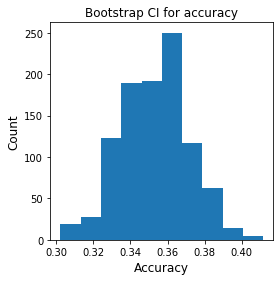

In [30]:
# Step 1: Model 
log_reg_estimator = LogisticRegression(random_state=10)

# Step 2: Identify Hyperparameters 
hyper_parameters = [{'multi_class': ['ovr'],
                     'C': [0.01, 0.1, 1, 10, 100, 1000]},
                    {'multi_class': ['multinomial'],
                     'C': [0.01, 0.1, 1, 10, 100, 1000],                
                     'solver': ['newton-cg']}]

# Step 3: Find Best Hyperparameters via CV GridSearch
best_params = CV_with_GridSearch(log_reg_estimator, 
                                 hyper_parameters, 
                                 cv=10)

# Step 4: Fit Model via Best Hyperparameters 
log_reg_classifier = LogisticRegression(random_state=10, 
                                        C=1000, 
                                        multi_class='ovr')

# Step 5: Evaluate model accuracy and confidence interval 
log_reg_classifier, train_accuracy_log_reg, validation_accuracy_log_reg, confidence_interval_log_reg = ( 
    estimate_model_results(log_reg_classifier, bootstrap_results=True) )

#### K-Nearest neighbors

Best parameters set found on development set:

{'n_neighbors': 1}

Grid scores on training set:

0.661 (+/-0.012) for {'n_neighbors': 1}
0.535 (+/-0.012) for {'n_neighbors': 2}
0.472 (+/-0.014) for {'n_neighbors': 3}
0.420 (+/-0.003) for {'n_neighbors': 4}
0.394 (+/-0.010) for {'n_neighbors': 5}
0.375 (+/-0.017) for {'n_neighbors': 6}
0.368 (+/-0.012) for {'n_neighbors': 7}
0.360 (+/-0.014) for {'n_neighbors': 8}
0.355 (+/-0.001) for {'n_neighbors': 9}
0.354 (+/-0.006) for {'n_neighbors': 10}
0.353 (+/-0.011) for {'n_neighbors': 11}
0.354 (+/-0.005) for {'n_neighbors': 12}
0.353 (+/-0.007) for {'n_neighbors': 13}
0.352 (+/-0.002) for {'n_neighbors': 14}
0.352 (+/-0.005) for {'n_neighbors': 15}
0.349 (+/-0.001) for {'n_neighbors': 16}
0.348 (+/-0.004) for {'n_neighbors': 17}
0.346 (+/-0.007) for {'n_neighbors': 18}
0.345 (+/-0.008) for {'n_neighbors': 19}
0.346 (+/-0.005) for {'n_neighbors': 20}
0.342 (+/-0.008) for {'n_neighbors': 21}
0.341 (+/-0.010) for {'n_neighbors': 22}
0.340 (+/-

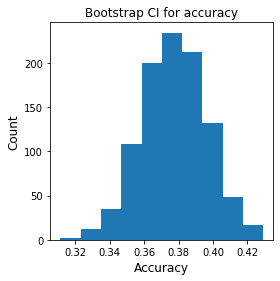

In [31]:
# Step 1: Model 
knn_estimator = KNeighborsClassifier()

# Step 2: Identify Hyperparameters 
hyper_parameters = [{'n_neighbors': range(1,50)}]

# Step 3: Find Best Hyperparameters via CV GridSearch
best_params = CV_with_GridSearch(knn_estimator, 
                                 hyper_parameters, 
                                 cv=10)

# Step 4: Fit Model via Best Hyperparameters 
knn_classifier = KNeighborsClassifier(n_neighbors=30)

# Step 5: Evaluate model accuracy and confidence interval 
knn_classifier, train_accuracy_knn, validation_accuracy_knn, confidence_interval_knn = ( 
    estimate_model_results(knn_classifier, bootstrap_results=True) )

#### Random Forest 

Best parameters set found on development set:

{'max_features': 4}

Grid scores on training set:

0.761 (+/-0.011) for {'max_features': 1}
0.771 (+/-0.018) for {'max_features': 2}
0.770 (+/-0.010) for {'max_features': 3}
0.774 (+/-0.013) for {'max_features': 4}
0.763 (+/-0.008) for {'max_features': 5}
0.766 (+/-0.010) for {'max_features': 6}
0.764 (+/-0.010) for {'max_features': 7}
0.761 (+/-0.011) for {'max_features': 8}
0.764 (+/-0.010) for {'max_features': 9}
Train labeling accuracy: 70.2 %
Val labeling accuracy: 59.0 %

Confusion matrix:
 [[46  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 15  1  0  1  0  0  0  6  6  1  1  0  0  0  0  4  1  5  1]
 [ 0  0 14  0  1  1  0  0  2  0  0  1  0  0  0  0  0  1  0  1]
 [ 0  0  0 39  0  0  0  0  0  2  1  0  0  0  0  0  0  0  0  0]
 [ 0  1  1  2 16  0  0  0  1  1  1  0  0  4  0  1  0  0  1  1]
 [ 0  0  0  0  0 16  1  0  6  3  3  1  0  4  0  3  1  0  0  3]
 [ 0  0  0  0  1  0 23  0  0  2  0  1  0  3  3  0  0  0  0  0]
 [ 0  1  1

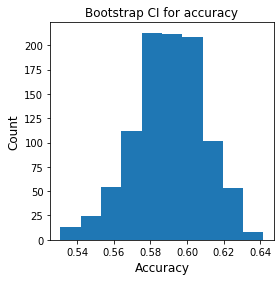

In [32]:
# Step 1: Model 
forest_estimator = RandomForestClassifier(n_estimators=100, 
                                          random_state=10)

# Step 2: Identify Hyperparameters 
num_features = range(1, len( features ))
hyper_parameters = [{'max_features': num_features}]

# Step 3: Find Best Hyperparameters via CV GridSearch 
best_params = CV_with_GridSearch(forest_estimator, 
                                 hyper_parameters, 
                                 cv=10)

# Step 4: Fit Model via Best Hyperparameters 
forest_classifier = RandomForestClassifier(n_estimators=500, 
                                           random_state=10, 
                                           max_features=6, 
                                           max_depth = 10)

# Step 5: Evaluate model accuracy and confidence interval 
forest_classifier, train_accuracy_forest, validation_accuracy_forest, confidence_interval_forest = ( 
    estimate_model_results(forest_classifier, bootstrap_results=True) )

#### Support Vector Machine

Note that the SVM classifier generally seems to favor larger classes in 'unbalanced' multicategorical training sets. Namely, our model ended up favoring the largest class in the image data set (i.e. gorilla category) by guessing 9 on all predictions, which is probably because there are way more images of Gorillas than any other category in the training data. As a result, we chose to use Logistic Regression that is not prone to this modelling issue. 

Best parameters set found on development set:

{'C': 1000, 'gamma': 0.5, 'kernel': 'rbf'}

Grid scores on training set:

0.069 (+/-0.001) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.191 (+/-0.008) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.302 (+/-0.010) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.349 (+/-0.012) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.372 (+/-0.011) for {'C': 1, 'gamma': 0.2, 'kernel': 'rbf'}
0.413 (+/-0.003) for {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}
0.191 (+/-0.008) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.307 (+/-0.008) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.334 (+/-0.016) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.404 (+/-0.017) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.452 (+/-0.011) for {'C': 10, 'gamma': 0.2, 'kernel': 'rbf'}
0.535 (+/-0.010) for {'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}
0.306 (+/-0.007) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.326 (+/-0.019) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'

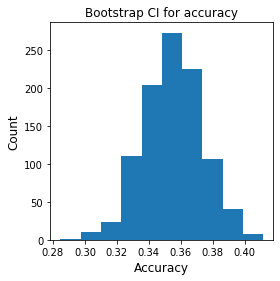

In [33]:
# Step 1: Model 
svm_estimator = SVC(decision_function_shape='ovr')

# Step 2: Identify Hyperparameters 
hyper_parameters = [{'kernel': ['rbf'],
                     'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 
                     'C': [1, 10, 100, 1000]}]

# Step 3: Find Best Hyperparameters via CV GridSearch 
best_params = CV_with_GridSearch(svm_estimator, 
                                 hyper_parameters, 
                                 cv=5)

# Step 4: Fit Model via Best Hyperparameters 
svm_classifier = SVC(decision_function_shape='ovr', 
                     C=1000, 
                     gamma=0.001, 
                     kernel='rbf') 

# Step 5: Evaluate model accuracy and confidence interval 
svm_classifier, train_accuracy_svm, validation_accuracy_svm, confidence_interval_svm = ( 
    estimate_model_results(svm_classifier, bootstrap_results=True) )

#### Model selection

In [34]:
classifier_results = pd.DataFrame(index=['Train Accuracy',
                                         'Validation Accuracy', 
                                         '95% Confidence Interval'])
classifier_results['Logistic Regression'] = [train_accuracy_log_reg,
                                             validation_accuracy_log_reg, 
                                             confidence_interval_log_reg]
classifier_results['KNN'] = [train_accuracy_knn,
                             validation_accuracy_knn, 
                             confidence_interval_knn]
classifier_results['Random Forest'] = [train_accuracy_forest,
                                       validation_accuracy_forest, 
                                       confidence_interval_forest]
classifier_results['SVM'] = [train_accuracy_svm,
                             validation_accuracy_svm, 
                             confidence_interval_svm]
classifier_results

,Logistic Regression,KNN,Random Forest,SVM
Train Accuracy,0.34,0.4,0.7,0.37
Validation Accuracy,0.35,0.38,0.59,0.36
95% Confidence Interval,"[0.32, 0.39]","[0.34, 0.41]","[0.55, 0.63]","[0.32, 0.39]"
